In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tysonpo/bike-ads-images-prices-specifications")

print("Path to dataset files:", path)

/Users/vloi/.pyenv/versions/3.10.6/envs/dataviz/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/vloi/.cache/kagglehub/datasets/tysonpo/bike-ads-images-prices-specifications/versions/4


## 🗺️ Prétraitement

In [4]:
file_path = os.path.join(os.curdir,'data/4','combined_price-only.csv')
image_directory = os.path.join(os.curdir,'data/4','images')
df = pd.read_csv(file_path).reset_index(drop=True)

In [5]:
X,y = [],[]

In [6]:
df.head()

,ID,Price
0,0,1399.99
1,2,2995.00
2,3,1049.00
3,4,929.35
4,5,199.00


In [23]:
resized_image = []
for ID in df['ID']:
    path = os.path.join(os.path.curdir,'data/4/images', f"{ID}.jpg")
    image = load_img(path, target_size=(224, 224))
    image_array = img_to_array(image)/255.0
    resized_image.append(image_array)


In [24]:
resized_image[100].shape

(224, 224, 3)

In [28]:
X = np.array(resized_image)
y = df['Price'].values
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 🎨 Création du modèle

* 🔹 weights='imagenet' : on charge les poids entraînés sur le gros dataset ImageNet
* 🔹 include_top=False : on retire la dernière couche dense qui classifie les images en 1000 catégories (on n’en a pas besoin ici)
* 🔹 input_shape=(224, 224, 3) : on définit que notre modèle va recevoir des images RGB 224x224

In [ ]:
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
base_model.trainable = False

In [ ]:
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1)(x)

In [20]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(), loss='mae', metrics=['mae'])

### Data Augmentation

On instancie une classe qui permet de faire l'aumgentation d'image (keras.preprocessing)

In [30]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)

In [31]:
model.fit(
    train_generator,
    validation_data=(X_test / 255.0, y_test),
    epochs=10
)

/Users/vloi/.pyenv/versions/3.10.6/envs/dataviz/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 102s 388ms/step - loss: 1837.0441 - mae: 1837.0441 - val_loss: 1435.6637 - val_mae: 1435.6637
Epoch 2/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 97s 384ms/step - loss: 1445.8912 - mae: 1445.8912 - val_loss: 1370.8068 - val_mae: 1370.8068
Epoch 3/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 93s 367ms/step - loss: 1412.4377 - mae: 1412.4377 - val_loss: 1371.1597 - val_mae: 1371.1597
Epoch 4/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 92s 366ms/step - loss: 1457.8870 - mae: 1457.8870 - val_loss: 1370.9486 - val_mae: 1370.9486
Epoch 5/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 92s 364ms/step - loss: 1422.7670 - mae: 1422.7670 - val_loss: 1370.9537 - val_mae: 1370.9537
Epoch 6/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 92s 364ms/step - loss: 1425.5811 - mae: 1425.5811 - val_loss: 1371.0969 - val_mae: 1371.0969
Epoch 7/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 93s 370ms/step - loss: 1415.1433 - mae: 1415.1433 - val_loss: 1370.6042 - val_mae: 1370.6042
Epoch 8/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 93s 368ms/step - loss: 1410.

In [32]:
y_pred = model.predict(X_test / 255.0)

63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 299ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 292ms/step


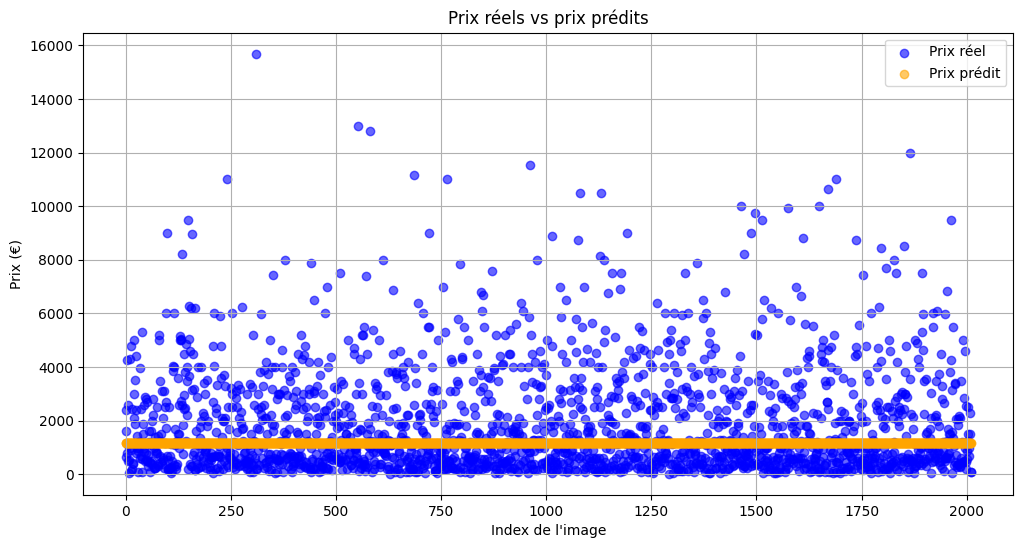

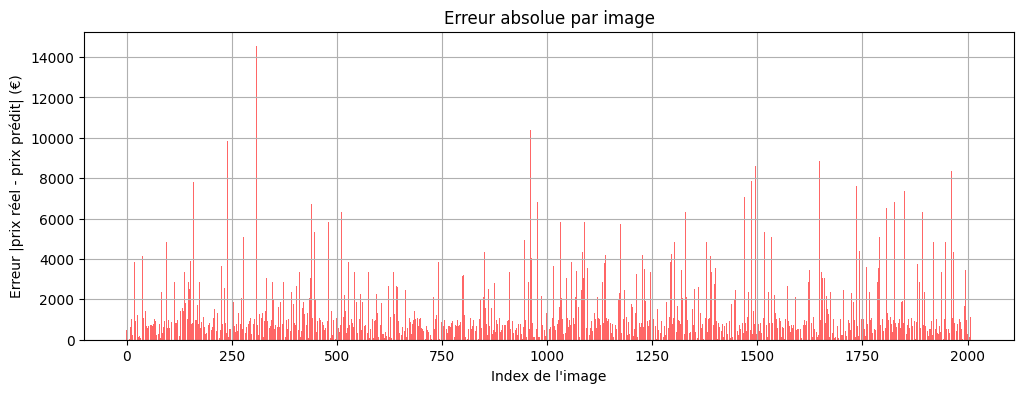

In [36]:
# Recalage des prédictions
y_pred = model.predict(X_test / 255.0).flatten()  # flatten pour avoir shape (n,)
y_true = y_test

# ⚫ 1. Nuage de points par image
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_true)), y_true, label='Prix réel', color='blue', alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, label='Prix prédit', color='orange', alpha=0.6)
plt.title("Prix réels vs prix prédits")
plt.xlabel("Index de l'image")
plt.ylabel("Prix (€)")
plt.legend()
plt.grid(True)
plt.show()

# 🔺 2. Graphique des erreurs absolues
plt.figure(figsize=(12, 4))
abs_errors = np.abs(y_true - y_pred)
plt.bar(range(len(abs_errors)), abs_errors, color='red', alpha=0.6)
plt.title("Erreur absolue par image")
plt.xlabel("Index de l'image")
plt.ylabel("Erreur |prix réel - prix prédit| (€)")
plt.grid(True)
plt.show()

In [37]:
y_pred

array([1154.976 , 1154.9773, 1154.9773, ..., 1154.976 , 1154.9757,
       1154.9716], dtype=float32)